<a href="https://colab.research.google.com/github/avcesar1981/llm_tutorials/blob/main/summarization/summary_refine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
#!pip install python-dotenv langfuse langchain langchain_community langchain_groq langgraph tiktoken
import os
from dotenv import load_dotenv, find_dotenv
from langchain_groq import ChatGroq
from langchain_community.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.prompts import ChatPromptTemplate
from langfuse.callback import CallbackHandler
from langchain_core.runnables import RunnableConfig
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph import END, START, StateGraph
from langfuse.callback import CallbackHandler
from typing import List, TypedDict

from google.colab import userdata

In [4]:
# Load environment variables
load_dotenv(find_dotenv())

# Langfuse tracing
langfuse_handler = CallbackHandler(
    public_key=userdata.get('LANGFUSE_PK'),
    secret_key=userdata.get('LANGFUSE_SK'),
    host=userdata.get('LANGFUSE_HOST')
)

In [5]:
def getLangfuseHandler():
    config = RunnableConfig(callbacks=[langfuse_handler])
    return config

In [6]:
def get_llm(model_name: str):
    return ChatGroq(model=model_name, temperature=0, api_key=userdata.get('GROQ_API_KEY'))

In [8]:
def split_docs(docs):
    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=4000, chunk_overlap=0)
    split_docs = text_splitter.split_documents(docs)
    return split_docs

In [7]:
loader = TextLoader("/content/sample_data/summary_refine.txt")
docs = loader.load()
docs

[Document(metadata={'source': '/content/sample_data/summary_refine.txt'}, page_content="welcome everyone to this special edition\nof Monday match analysis I'm Gil gross\nand it is time for a preview of the 2025\nAustralian Open men's final between\nyanic Sinner and Alexander verev cner\nwinner of the last two hardcourt slams\nhe looks to make it three and snatch the\nthird major title of his career Zev\ngoing for Numero Uno it is his third\nopportunity at that\nI will go through both players paths to\nVictory I'll make a prediction at the\nend I've already made a YouTube video\nreacting to jovic's retirement against\nverev in the semifinal that is not going\nto go up on audio so that's YouTube\nexclusive but what I will talk about on\nthis particular show which will be\navailable on all podcast platforms uh is\nthe second semifinal played last night\nyanx CER straight set win over Ben\nShelton very nearly was not as Ben broke\nCenter sered twice in the first set\nreally\nimpressively s

In [9]:
llm = get_llm("deepseek-r1-distill-qwen-32b")

In [12]:
split_docs = split_docs(docs)

In [14]:
summarize_prompt = ChatPromptTemplate.from_messages(
    [("system","""
      You are an expert information synthesis assistant. Your task is to generate a summary of a text provided.
      The summary should be clear, structured, and convey all the essential information from the text.

      Follow these guidelines:

      Contextualization: Start with a brief introduction explaining the main theme of the topic.
      Structure: Organize the summary into logical sections, such as main topics, relevant insights, and conclusions.
      Detailing: Include explanations and examples mentioned in the text, avoiding generic phrases.
      Tone and Style: Write in an objective and informative manner, without altering the meaning of the original content.
      Highlights: If there are important facts, statistics, or quotes, highlight them in the summary.
      Here is the text:

      {context}

      Now generate the summary following the above guidelines.""")]
)

In [20]:
refine_template = """
        Generate a final summary.

        Partial summary up to this point:
        {existing_answer}

        New context:
        ------------
        {context}
        ------------

        Given the new context, refine the partial summary."""

refine_prompt = ChatPromptTemplate([
    ("human", refine_template)
])

In [21]:
initial_summary_chain = summarize_prompt | llm | StrOutputParser()
refine_summary_chain = refine_prompt | llm | StrOutputParser()

In [25]:
# Define state for LangGraph
class State(TypedDict):
    contents: List[str]
    index: int
    summary: str

In [26]:
 # Define state
config = getLangfuseHandler()

# Generate initial summary
async def generate_initial_summary(state: State):
    summary = await initial_summary_chain.ainvoke(state["contents"][0], config)
    return {"summary": summary, "index": 1}

# Refine summary
async def refine_summary(state: State):
    content = state["contents"][state["index"]]
    summary = await refine_summary_chain.ainvoke(
        {"existing_answer": state["summary"], "context": content}, config
    )
    return {"summary": summary, "index": state["index"] + 1}

# Check if we should refine
def should_refine(state: State):
    return "refine_summary" if state["index"] < len(state["contents"]) else END

# Build processing graph
graph = StateGraph(State)
graph.add_node("generate_initial_summary", generate_initial_summary)
graph.add_node("refine_summary", refine_summary)
graph.add_edge(START, "generate_initial_summary")
graph.add_conditional_edges("generate_initial_summary", should_refine)
graph.add_conditional_edges("refine_summary", should_refine)
app_graph = graph.compile()

# Process asynchronously
final_summary = None
async for step in app_graph.astream(
    {"contents": split_docs, "index": 0, "summary": ""},
    stream_mode="values",
    config=config
):
    if "summary" in step:
        final_summary = step["summary"]

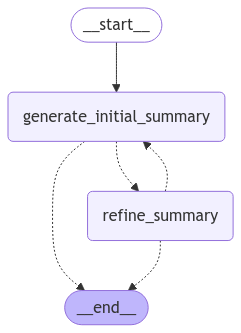

In [31]:
from IPython.display import Image

Image(app_graph.get_graph().draw_mermaid_png())

In [28]:
import re

def remove_think_content_and_tags(text):
  """
  Removes all content between <think> and </think> tags, including the tags themselves, from a string.

  Args:
    text: The input string containing <think> tags.

  Returns:
    The string with all <think> and </think> sections removed.
  """
  pattern = r"<think>.*?</think>"
  cleaned_text = re.sub(pattern, "", text, flags=re.DOTALL)
  return cleaned_text

In [29]:
# Remove the content between <think> </think> when use deepseek model
cleaned_result = remove_think_content_and_tags(final_summary)

# Print the cleaned content
print(cleaned_result)



### Final Summary

The 2025 Australian Open men's final between Yannick Sinner and Alexander Zverev promises to be a thrilling clash of contrasting styles and strategies. Here's a breakdown of the key factors that could influence the outcome:

#### **Yannick Sinner's Path to Victory**
- **Consistency and Adaptability**: Sinner has consistently demonstrated his ability to adapt to opponents' styles. His improved backhand and overall consistency have been key to his progression.
- **Mental Resilience**: Sinner is known for his clutch performance, particularly in tie-breaks, where he has a 23-3 record in the last two years. His ability to stay composed under pressure is a significant advantage.
- **Forehand Firepower**: Sinner's forehand is a weapon, and he is likely to target Zverev's weaker backhand to gain an edge.

#### **Alexander Zverev's Path to Victory**
- **Serve and Return**: Zverev's serve is a dominant weapon, and his ability to return effectively has been crucial. He has sh